In [4]:
try:
    import mesa
except ImportError:
    !pip install mesa
    import mesa

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Resource Classes

In [32]:
class Sugar(mesa.Agent):

    def __init__(self, model, pos, max_sugar):
        super().__init__(model)

        self.amount = max_sugar
        self.max_sugar = max_sugar





In [ ]:
class Spice(mesa.Agent):

    def __init__(self, model, pos, max_spice):
        super().__init__(model)
        self.amount = max_spice
        self.max_spice = max_spice



In [ ]:
class Trader(mesa.Agent):
    def __init__(self, model, pos):
        super().__init__(model)
        self.pos = pos
        print("I am trader")


# model class

In [37]:
class SugarscapeG1mt(mesa.Model):
    def __init__(self, width=50, height=50):
        # 부모 클래스(mesa.Model) 초기화
        super().__init__()


        self.width = width
        self.height = height

        # torus=True로 하면 팩맨처럼 맵이 연결됩니다.
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)



        self.sugar_distribution = np.genfromtxt("sugar-map.txt")
        self.spice_distribution = np.flip(self.sugar_distribution, axis=0)

        # 도화지를 가로로 길게(12x6 크기) 준비합니다.
        plt.figure(figsize=(12, 6))

        # 첫 번째 그림: 설탕 지도 (1행 2열 중 1번째)
        plt.subplot(1, 2, 1)
        plt.imshow(self.sugar_distribution, origin="lower", cmap="Oranges")
        plt.title("Sugar Map")
        plt.colorbar()

        # 두 번째 그림: 향신료 지도 (1행 2열 중 2번째)
        plt.subplot(1, 2, 2)
        plt.imshow(self.spice_distribution, origin="lower", cmap="BuPu")
        plt.title("Spice Map")
        plt.colorbar()


        for _, (x, y) in self.grid.coord_iter():
            max_sugar = self.sugar_distribution[x, y]
            if max_sugar > 0:
                sugar = Sugar(self, (x,y), max_sugar)
                self.grid.place_agent(sugar, (x, y))

            max_spice = self.spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(self, (x,y), max_spice)
                self.grid.place_agent(spice, (x, y))





# Run Model


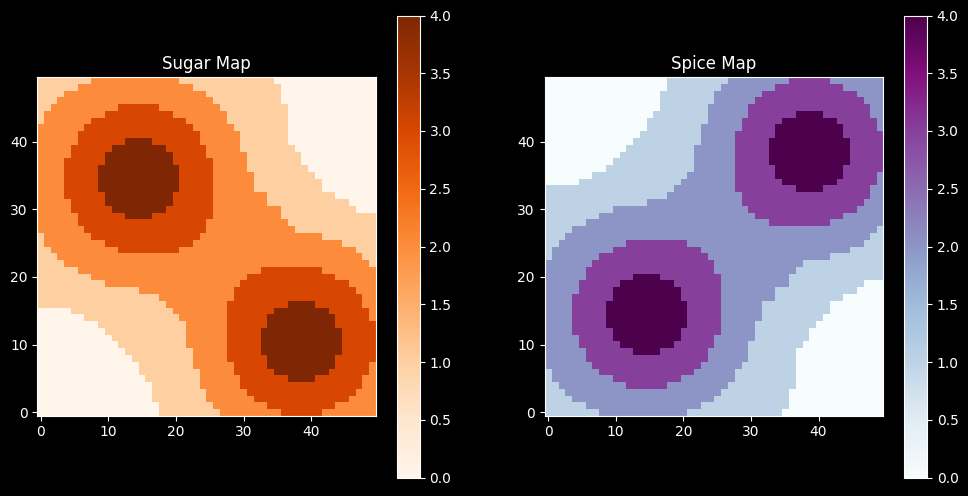

In [38]:
model = SugarscapeG1mt()

In [34]:
print(model.sugar_distribution)
print()

[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
